<a href="https://colab.research.google.com/github/StevenMena/07MIAR_RedesNeu_DeepLearning/blob/main/07MIAR_VC04_VC05_Deep_Vision_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07MAIR - Redes Neuronales y Deep Learning
## VC04_V05: Deep Learning y Deep vision

In [ ]:
# SOLO PARA USO EN GOOGLE COLABORATORY
# Para conectar el notebook con la cuenta de gdrive
from google.colab import drive
drive.mount('/content/drive/')

BASE_FOLDER = '/content/drive/My Drive/VIU/Docencia/MAIR_10_2020-21/07MAIR/' # Se debe garantizar que la carpeta docencia compartida se almacena en el directorio raíz de Google Drive. En caso contrario modificar este path

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **INTRODUCCIÓN A LAS CONVOLUTIONAL NEURAL NETWORKS: MNIST DATASET**

#### **- Cargando el conjunto de datos**

In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#print(x_train.shape)
#print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step


#### **- Acondicionando el conjunto de datos**

In [ ]:
# Pre-procesado obligatorio cuando trabajo con redes neuronales
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import expand_dims

#Normalizando los datos
x_train, x_te = x_train / 255.0, x_test / 255.0 #Cambio al rango 0-1 -> Disminuyo CC
#¿Que pasa si empleo labels con etiquetas número entero?
print(y_train[0])

#One-hot encoding para minimizar error
#Que implicaciones hay de no transformar la data en one-hot encoding
#Bueno en vez de utilizar en la función de perdida categorical_crossentropy usaremos sparse_categorical_crossentropy
#y_train = to_categorical(y_train, num_classes=10) 
#y_te = to_categorical(y_test, num_classes=10)

#Creando mi data de validación
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42) # 3 subconjuntos es de vital importancia

#Expandir dimensiones porque en CNN tengo que especificar el número de canales
#las imagenes del data set son grayscale, por lo tanto solo tiene 2 dimensones (ancho, alto)
#y la red convolucional espera 3 dimensiones, por ello ocupamos expand_dims
#que nos sirve para agregar una dimensión adicional de tamaño 1 en la posición de los canales de color, 
#transformando la forma de los datos de entrada en (ancho, alto, 1), que es compatible con la capa de convolución. 
print(x_tr.shape)
x_tr = expand_dims(x_tr, axis=3)
x_val = expand_dims(x_val, axis=3)
x_te = expand_dims(x_te, axis=3)
print(x_tr.shape)

#En el resultado podemos observar que nuestro dataset se componene por 54,000 ejemplos
#Cada ejemplo de 28x28 pixeles, en una sola dimensión 

5
(54000, 28, 28)
(54000, 28, 28, 1)


#### **- Creando la topología de Red Neuronal (CNN) y entrenándola**

In [ ]:
# Construccion de una red CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
# Red feedforward API secuencial
#Al utilizar el model secuencial, significa que las de mi modelo capas se van trabajando secuencialmente
#pero hay otro tipo de modelos que no sean secuenciales
#Inicialización del objeto que contendra todo lo relacionado a nuestro modelo
convnet = Sequential()

# BASE MODEL o ENCODER
#Definiendo la primer capa convolucional el primer parámetro hace referencia al número de filtros que se van aplicar, 32 filtros
#el siguiente parámetro hace referencia a la dimensiones de los filtros que se van aplicar en este caso son de 3x3 dimensiones
#el tercer parámetro es la data de entrada, ya que esta es la primer capa necesitamos definir la entrada de nuestro data set 
#y el último parámetro la función de activación de esta capa
convnet.add(layers.Conv2D(32,(3,3),input_shape=(28,28,1),activation='relu'))
#Se aplica max pooling a la salida de esta primer capa con el fin de reducir a la mitad la dimensiones en x e y, el volumen(z) no se ve afectado.
#El maxpooling no tiene parámetros entrenables.
convnet.add(layers.MaxPooling2D((2,2)))

convnet.add(layers.Conv2D(64,(3,3),activation='relu'))
convnet.add(layers.MaxPooling2D((2,2)))

convnet.add(layers.Conv2D(64,(3,3),activation='relu'))

#TOP MODEL o MLP (Multi-Layer Perceptron)
convnet.add(layers.Flatten())
convnet.add(layers.Dense(64,activation='relu'))
convnet.add(layers.Dense(10,activation='softmax'))

In [ ]:
#Da como resultado la salida de cada capaa, los parámetros entrenables por cada capa
#y el total de parámetros del modelo.
convnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [ ]:
#Configurar el modelo para su entrenamiento
#Se establece la función de optimización
#la función de perdida
#y la métrica con la que será evaluada el modelo.
convnet.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               #loss='categorical_crossentropy', #If labels are one-hot encoded
               metrics=['accuracy'])

In [ ]:
#Entrenar el modelo
#Cuando se entrena el modelo se necesita asiganarle el dataset de train con sus respectivos labels
#las épocas en la que se entrenara el modelo
#El número de batch, cada vez que se llegué a ese número de actualizan los pesos de mi red
#El dataset de validación con sus respectivos labels.
H = convnet.fit(x_tr, y_tr, epochs=5, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/5
422/422 [==============================] - 14s 6ms/step - loss: 0.2796 - accuracy: 0.9152 - val_loss: 0.0762 - val_accuracy: 0.9800
Epoch 2/5
422/422 [==============================] - 2s 5ms/step - loss: 0.0721 - accuracy: 0.9778 - val_loss: 0.0590 - val_accuracy: 0.9827
Epoch 3/5
422/422 [==============================] - 2s 5ms/step - loss: 0.0484 - accuracy: 0.9850 - val_loss: 0.0422 - val_accuracy: 0.9873
Epoch 4/5
422/422 [==============================] - 2s 5ms/step - loss: 0.0378 - accuracy: 0.9881 - val_loss: 0.0397 - val_accuracy: 0.9885
Epoch 5/5
422/422 [==============================] - 2s 5ms/step - loss: 0.0292 - accuracy: 0.9909 - val_loss: 0.0351 - val_accuracy: 0.9892


#### **- Observando el proceso de entrenamiento para tomar decisiones**

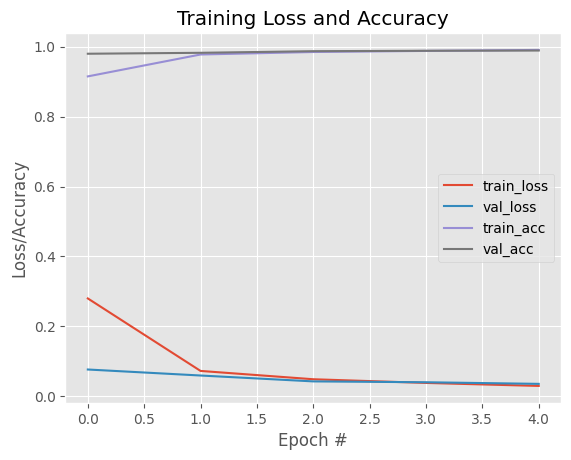

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 5), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 5), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 5), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 5), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#Se puede observar que con 5 épocas el training loss y el val loss tienen a ir a cero 
#Esto quiere decir que el modelo esta prediciendo bien o esta generalizando

#### **- Probando el conjunto de datos en el subset de test y evaluando el performance del modelo**

In [ ]:
from sklearn.metrics import classification_report
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")
predictions = convnet.predict(x_te, batch_size=128)
print(y_test[0])
print(predictions[0])
print(predictions[0].argmax())
#Obtener diferentes métricas de lo predicho y el grand true
#print(classification_report(y_test, predictions.argmax(axis=1)))

[INFO]: Evaluando red neuronal...
79/79 [==============================] - 0s 2ms/step
7
[5.3458264e-09 3.4021205e-08 1.3523994e-06 4.1587228e-07 5.9193251e-08
 1.3567093e-09 2.5907921e-14 9.9999392e-01 2.5105003e-08 4.1888247e-06]
7


## **¿POR QUE CONVOLUTIONAL NEURAL NETWORKS?: CIFAR DATASET**

#### **- Cargando el conjunto de datos y acondicionándolo**

In [2]:
# Importando el set de datos CIFAR10, imagenes de 32x32 pixeles a color, RGB
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer
print("[INFO]: Loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
#tipos de clases
labelNames = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camión"]
print(trainX.shape)
print(trainY.shape)


# Por si es necesario convertir a one-hot encoding
#lb = LabelBinarizer()
#trainY = lb.fit_transform(trainY)
#testY = lb.transform(testY)

[INFO]: Loading CIFAR-10 data...
(50000, 32, 32, 3)
(50000, 1)
[6]


In [3]:
#Pixeles de la muestra 0
print(trainX[0])
#Label de la muestra 0
print(trainY[0])

print(testX.shape)
print(testY.shape)

[[[0.23137255 0.24313725 0.24705882]
  [0.16862745 0.18039216 0.17647059]
  [0.19607843 0.18823529 0.16862745]
  ...
  [0.61960784 0.51764706 0.42352941]
  [0.59607843 0.49019608 0.4       ]
  [0.58039216 0.48627451 0.40392157]]

 [[0.0627451  0.07843137 0.07843137]
  [0.         0.         0.        ]
  [0.07058824 0.03137255 0.        ]
  ...
  [0.48235294 0.34509804 0.21568627]
  [0.46666667 0.3254902  0.19607843]
  [0.47843137 0.34117647 0.22352941]]

 [[0.09803922 0.09411765 0.08235294]
  [0.0627451  0.02745098 0.        ]
  [0.19215686 0.10588235 0.03137255]
  ...
  [0.4627451  0.32941176 0.19607843]
  [0.47058824 0.32941176 0.19607843]
  [0.42745098 0.28627451 0.16470588]]

 ...

 [[0.81568627 0.66666667 0.37647059]
  [0.78823529 0.6        0.13333333]
  [0.77647059 0.63137255 0.10196078]
  ...
  [0.62745098 0.52156863 0.2745098 ]
  [0.21960784 0.12156863 0.02745098]
  [0.20784314 0.13333333 0.07843137]]

 [[0.70588235 0.54509804 0.37647059]
  [0.67843137 0.48235294 0.16470588]


#### **- Inspeccionando el conjunto de datos**

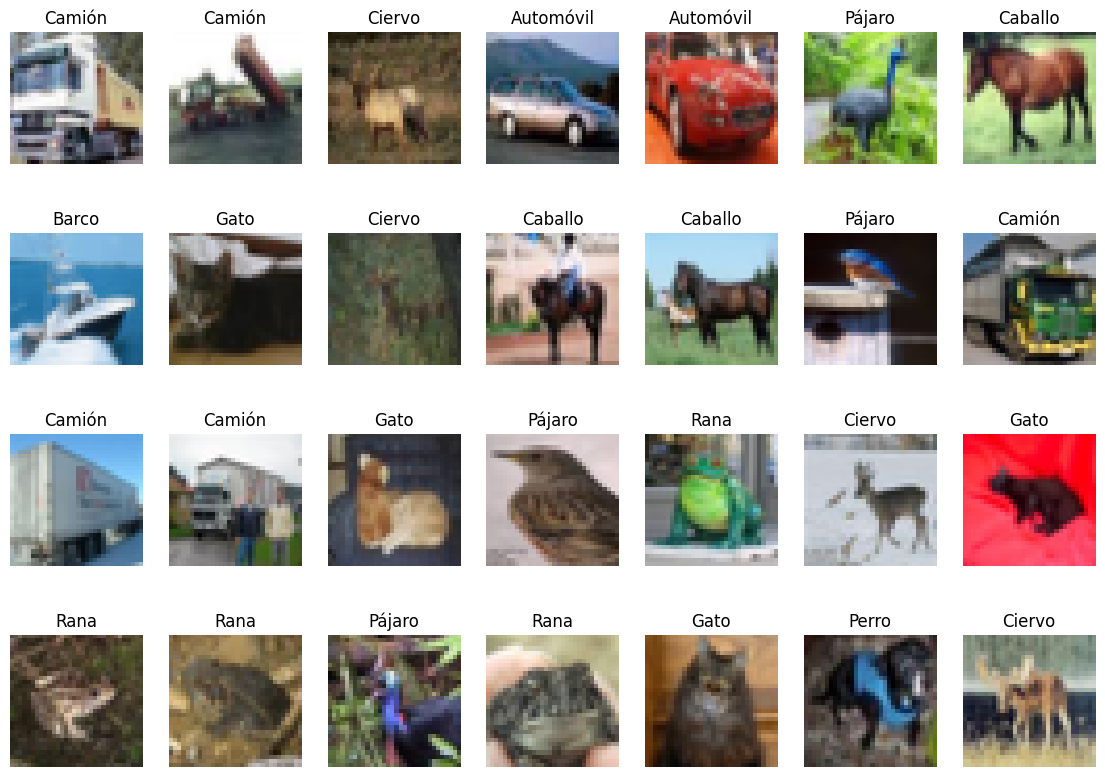

In [4]:
#Las imagenes están bien pixeleadas, en algunas no se puede identificar a simple vista a que clase pertenece
#esto hace que el problema de clasificación sea más complejo.
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,10))
for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    img = trainX[n]
    plt.imshow(img)
    plt.title(labelNames[trainY[n][0]])
    plt.axis('off')

#### **- Creando la topología de red neuronal y entrenándola: MLP**

[INFO]: Entrenando red neuronal...
Epoch 1/50
1250/1250 [==============================] - 12s 6ms/step - loss: 1.9124 - accuracy: 0.3061 - val_loss: 1.7964 - val_accuracy: 0.3676
Epoch 2/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6869 - accuracy: 0.3969 - val_loss: 1.6245 - val_accuracy: 0.4203
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5934 - accuracy: 0.4319 - val_loss: 1.5765 - val_accuracy: 0.4399
Epoch 4/50
1250/1250 [==============================] - 6s 4ms/step - loss: 1.5269 - accuracy: 0.4537 - val_loss: 1.5435 - val_accuracy: 0.4517
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4730 - accuracy: 0.4736 - val_loss: 1.5016 - val_accuracy: 0.4669
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4318 - accuracy: 0.4893 - val_loss: 1.4827 - val_accuracy: 0.4755
Epoch 7/50
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3892 - accuracy: 0.503

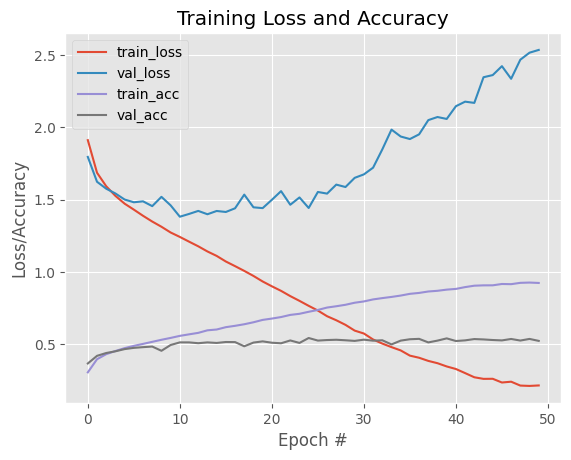

In [5]:
# Imports necesarios
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Arquitectura de red
# Definimos el modo API Sequential
model = Sequential() #(X)
#El MLP no puede procesar datos de 3 dimensiones, por eso aplanamos la data
model.add(Flatten()) #(X)
# Primera capa oculta
model.add(Dense(2048, input_shape=(32*32*3,), activation="relu")) #(X)
#model.add(Dropout(0.5))
# Segunda capa oculta
model.add(Dense(1024, activation="relu")) #(X)
#model.add(Dropout(0.5))
# Tercera capa oculta
model.add(Dense(512, activation="relu")) #(X)
#model.add(Dropout(0.5))
# Cuarta capa oculta
model.add(Dense(128, activation="relu")) #(X)
#model.add(Dropout(0.5))
# Quinta capa oculta
model.add(Dense(32, activation="relu")) #(X)
# Capa de salida
model.add(Dense(10, activation="softmax")) #(X)


# Compilamos el modelo y entrenamos
print("[INFO]: Entrenando red neuronal...")
# Compilamos el modelo
model.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(0.01), metrics=["accuracy"]) # Etiquetas en decimal #(X)
# model.compile(loss="categorical_crossentropy", optimizer=SGD(0.01), metrics=["accuracy"]) # Etiquetas binarias #(X)
# Entrenamos el perceptrón multicapa
H = model.fit(trainX, trainY, validation_split=0.2, epochs=50, batch_size=32) #(X)

# Evaluamos con las muestras de test
print("[INFO]: Evaluando modelo...")
# Efectuamos predicciones
predictions = model.predict(testX, batch_size=32) #(X)
# Obtenemos el report
print(classification_report(testY, predictions.argmax(axis=1), target_names=labelNames)) # Etiquetas en decimal #(X)
# print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames)) # Etiquetas binarias

# Mostramos gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#El modelo usando MLP no generaliza bien y existe un overfitting bien grande.

#### **- Creando la topología de red neuronal y entrenándola: CNN**

In [ ]:
# Import the necessary packages
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

#########################################
###### Definimos la arquitectura ########
#########################################
#Importante no se esta usando un modelo secuencial, en vez se está usando un modelo funcional.

#BASE MODEL
# Definimos entradas
inputs = Input(shape=(trainX.shape[1], trainX.shape[2], trainX.shape[3]))

#Declaramos el modelo funcional
# Primer set de capas CONV => RELU => CONV => RELU => POOL
# La entrada en cada cálculo se ve representado luego de la definición de la función entre ()
#Por ejemplo en la línea de BatchNormalization la entrada es x1
x1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs) 
x1 = BatchNormalization()(x1) 
x1 = Conv2D(32, (3, 3), padding="same", activation="relu")(x1) 
x1 = BatchNormalization()(x1) 
x1 = MaxPooling2D(pool_size=(2, 2))(x1) 
x1 = Dropout(0.25)(x1) 

# Segundo set de capas CONV => RELU => CONV => RELU => POOL
x2 = Conv2D(64, (3, 3), padding="same", activation="relu")(x1) #(X)
x2 = BatchNormalization()(x2) #(X)
x2 = Conv2D(64, (3, 3), padding="same", activation="relu")(x2) #(X)
x2 = BatchNormalization()(x2) #(X)
x2 = MaxPooling2D(pool_size=(2, 2))(x2) #(X)
x2 = Dropout(0.25)(x2) #(X)

# Tercer set de capas CONV => RELU => CONV => RELU => POOL
#Entrada x2
x3 = Conv2D(256, (3, 3), padding="same", activation="relu")(x2) #(X)
x3 = BatchNormalization()(x3) #(X)
x3 = Conv2D(256, (3, 3), padding="same", activation="relu")(x3) #(X)
x3 = BatchNormalization()(x3) #(X)
x3 = MaxPooling2D(pool_size=(2, 2))(x3) #(X)
x3 = Dropout(0.25)(x3) #(X)

# TOP MODEL
# Primer (y único) set de capas FC => RELU
#Entrada x3
xfc = Flatten()(x3) #(X)
xfc = Dense(512, activation="relu")(xfc) #(X)
xfc = BatchNormalization()(xfc) #(X)
xfc = Dropout(0.5)(xfc) #(X)
# Clasificador softmax
predictions = Dense(10, activation="softmax")(xfc) #(X)

# Unimos las entradas y el modelo mediante la función Model con parámetros inputs y ouputs (Consultar la documentación)
#Esto quiere decir que la función model tomará todo lo que se encuentre en las variables input y output
model_cnn = Model(inputs=inputs, outputs=predictions) #(X)

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
model_cnn.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) #(X)

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H = model_cnn.fit(trainX, trainY, validation_split=0.2, batch_size=128, epochs=50, verbose=1) #(X)

# Almaceno el modelo en Drive
# Montamos la unidad de Drive
drive.mount('/content/drive') #(X)
# Almacenamos el modelo empleando la función mdoel.save de Keras
model_cnn.save(BASE_FOLDER+"deepCNN_CIFAR10.h5") #(X)

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = model_cnn.predict(testX, batch_size=128) #(X)
# Sacamos el report para test
print(classification_report(testY, predictions.argmax(axis=1), target_names=labelNames)) #(X)

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/50
313/313 [==============================] - 17s 30ms/step - loss: 1.6329 - accuracy: 0.4641 - val_loss: 2.8772 - val_accuracy: 0.1895
Epoch 2/50
313/313 [==============================] - 9s 27ms/step - loss: 1.0817 - accuracy: 0.6253 - val_loss: 1.1423 - val_accuracy: 0.6167
Epoch 3/50
313/313 [==============================] - 9s 27ms/step - loss: 0.8512 - accuracy: 0.7036 - val_loss: 0.9432 - val_accuracy: 0.6749
Epoch 4/50
313/313 [==============================] - 9s 27ms/step - loss: 0.7292 - accuracy: 0.7457 - val_loss: 0.8582 - val_accuracy: 0.7181
Epoch 5/50
313/313 [==============================] - 9s 28ms/step - loss: 0.6404 - accuracy: 0.7756 - val_loss: 0.6749 - val_accuracy: 0.7651
Epoch 6/50
313/313 [==============================] - 9s 28ms/step - loss: 0.5683 - accuracy: 0.8000 - val_loss: 0.6607 - val_accuracy: 0.7802
Epoch 7/50
313/313 [==============================] - 9s 29ms/step - loss: 0.528

NameError: ignored

## **REDUCIENDO OVERFITTING MEDIANTE DATA AUGMENTATION**

#### **- Acondicionando dataset**

In [ ]:
from sklearn.preprocessing import LabelBinarizer
# Por si es necesario convertir a one-hot encoding
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
print(trainY.shape)
print(testY.shape)

(50000, 10)
(10000, 10)


#### **- Creando un contenedor DataGenerator para el aumento automático de muestras**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#todos los parámetros que se han establecido son las modificaciones que se le harán a la imagen  original
#pero el ImageDataGenerator lo hace aleatoriamente, osea que la primer imagen puede ser un mirror y la otra un zoom, así 
#sucesivamente
#pero los valores que se le asigan a estos parámetros, ya que se pueden generar imagenes que no representen de ninguna forma la figura
# y cuando esto sucede lejos de ayudar al modelo generando nuevas imagenes se le metería ruido de imagenes que no ayudarían a generalizar al modelo.
datagen = ImageDataGenerator(
    rotation_range=15, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    # shear_range=0, # deslizamiento
    zoom_range=0.2, # rango de zoom
    # fill_mode='nearest', # como rellenar posibles nuevos pixeles
    # channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
    #Crear un dataset de validation
    validation_split=0.2
)

#### **- Inspeccionando las muestras generadas sintéticamente**

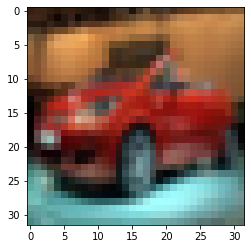

Label = Automóvil


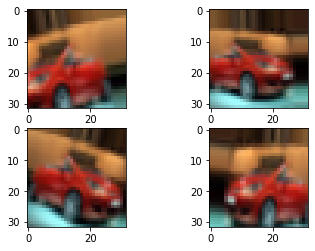

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

sample = 45
plt.imshow(image.array_to_img(trainX[sample]))
plt.show()
print('Label = {}'.format(labelNames[trainY[sample].argmax(axis=0)]))

fig, axes = plt.subplots(2,2)
i = 0
for batch in datagen.flow(trainX[sample].reshape((1,32,32,3)),batch_size=1):
    #plt.figure(i)
    axes[i//2,i%2].imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 4:
        break
plt.show()

#### **- Creando la topología de red neuronal y entrenándola: CNN**

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/50
391/390 [==============================] - 28s 72ms/step - loss: 1.6073 - accuracy: 0.4650 - val_loss: 2.1563 - val_accuracy: 0.3214
Epoch 2/50
391/390 [==============================] - 28s 71ms/step - loss: 1.0984 - accuracy: 0.6101 - val_loss: 0.9950 - val_accuracy: 0.6575
Epoch 3/50
391/390 [==============================] - 28s 72ms/step - loss: 0.9295 - accuracy: 0.6713 - val_loss: 1.6674 - val_accuracy: 0.5454
Epoch 4/50
391/390 [==============================] - 28s 71ms/step - loss: 0.8523 - accuracy: 0.7026 - val_loss: 0.9277 - val_accuracy: 0.6814
Epoch 5/50
391/390 [==============================] - 28s 70ms/step - loss: 0.7605 - accuracy: 0.7351 - val_loss: 0.9631 - val_accuracy: 0.6986
Epoch 6/50
391/390 [==============================] - 28s 71ms/step - loss: 0.7058 - accuracy: 0.7547 - val_loss: 0.7450 - val_accuracy: 0.7574
Epoch 7/50
391/390 [==============================] - 28s 71ms/step - loss:

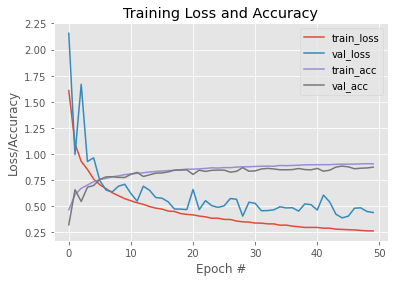

In [ ]:
# Import the necessary packages
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

#########################################
###### Definimos la arquitectura ########
#########################################
# Definimos entradas
inputs = Input(shape=(trainX.shape[1], trainX.shape[2], trainX.shape[3]))

# Primer set de capas CONV => RELU => CONV => RELU => POOL
x1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs) 
x1 = BatchNormalization()(x1) 
x1 = Conv2D(32, (3, 3), padding="same", activation="relu")(x1) 
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(pool_size=(2, 2))(x1) 
x1 = Dropout(0.25)(x1) 

# Segundo set de capas CONV => RELU => CONV => RELU => POOL
x2 = Conv2D(64, (3, 3), padding="same", activation="relu")(x1) 
x2 = BatchNormalization()(x2) 
x2 = Conv2D(64, (3, 3), padding="same", activation="relu")(x2) 
x2 = BatchNormalization()(x2) 
x2 = MaxPooling2D(pool_size=(2, 2))(x2) 
x2 = Dropout(0.25)(x2) 

# Segundo set de capas CONV => RELU => CONV => RELU => POOL
x2 = Conv2D(256, (3, 3), padding="same", activation="relu")(x2) 
x2 = BatchNormalization()(x2) 
x2 = Conv2D(256, (3, 3), padding="same", activation="relu")(x2) 
x2 = BatchNormalization()(x2) 
x2 = MaxPooling2D(pool_size=(2, 2))(x2) 
x2 = Dropout(0.25)(x2) 

# Primer (y único) set de capas FC => RELU
xfc = Flatten()(x2) 
xfc = Dense(512, activation="relu")(xfc) 
xfc = BatchNormalization()(xfc) 
xfc = Dropout(0.5)(xfc) 
# Clasificador softmax
predictions = Dense(10, activation="softmax")(xfc) 

# Unimos las entradas y el modelo mediante la función Model con parámetros inputs y ouputs (Consultar la documentación)
model_aug = Model(inputs=inputs, outputs=predictions) 

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
model_aug.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) 

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
#Se ocupa flow porque los datos ya están cargados en memoria
#Cambiar el validation data, crear un validation data 
H_aug = model_aug.fit(datagen.flow(trainX, trainY, batch_size=128,subset='training'),
                                steps_per_epoch = len(trainX)/ 128, epochs=50, validation_data=datagen.flow(trainX, trainY, batch_size=128,subset='validation'))
# Almaceno el modelo en Drive
# Montamos la unidad de Drive
drive.mount('/content/drive') 
# Almacenamos el modelo empleando la función mdoel.save de Keras
model_aug.save(BASE_FOLDER+"deepCNN_CIFAR10_aug.h5") 

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = model_aug.predict(testX, batch_size=128) 
# Sacamos el report para test
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames)) 

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H_aug.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H_aug.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), H_aug.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 50), H_aug.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

**EJERCICIO PROPUESTO:** Modificar la ejecución con Data Augmentation para que sea directamente comparable a la ejecución por defecto. Para ello, el validation data debe ser correcto. Pista: Llevar a cabo el validation split cuando se instancia el objeto ImageDataGenerator. El método flow también se verá afectado (leer documentación).

## **TRABAJANDO CON REDES PRE-ENTRENADAS: TRANSFER LEARNING & FINE-TUNING**


#### **- Cargando el conjunto de datos y acondicionándolo como en la VGG**

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import imagenet_utils
from sklearn.preprocessing import LabelBinarizer

# Importando y normalizando el set de datos CIFAR10
print("[INFO]: Loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
labelNames = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camión"]

#One-hot encoding
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# IMPORTANTE: Se normalizan los datos como se normalizaron en el entrenamiento con ImageNet!!
trainX = imagenet_utils.preprocess_input(trainX)
testX = imagenet_utils.preprocess_input(testX)

#print(trainX.shape)
#print(trainY.shape)

[INFO]: Loading CIFAR-10 data...
170500096/170498071 [==============================] - 2s 0us/step


#### **- Cargando la topología de CNN (base model)**

In [ ]:
#keras incluye varias arquitecturas
# VGG16, VGG19, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, RasNet
# documentacion https://keras.io/applications/
# Visual Geometry Group 16 / 19 (numero de layers)
# 1 y 2 en la competicion ImageNet 2014
# Kernels pequeños de 3x3

from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet',
                 include_top=False, # No incluir el top model, i.e. la parte densa destinada a la clasificación (fully connected layers)
                 input_shape=(32,32,3))
base_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

#### **- Creando el top model y congelando TODAS las capas convolucionales (TRANSFER LEARNING)**

In [ ]:
# conectarlo a nueva parte densa
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

#Congelar todos los pesos del base model, ya que queremos reutilizar los pesos de VGG16
#Por esto el total de los params entrenables solo serán los params de mi MLP o Top Model
base_model.trainable = False # Evitar que los pesos se modifiquen en la parte convolucional -> TRANSFER LEARNING
pre_trained_model = Sequential()
pre_trained_model.add(base_model)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(layers.Dense(256, activation='relu'))
pre_trained_model.add(layers.Dense(10, activation='softmax'))

pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


#### **- Entrenando la solución**

[INFO]: Compilando el modelo...
[INFO]: Entrenando la red...
Epoch 1/20
313/313 [==============================] - 5s 15ms/step - loss: 3.4711 - accuracy: 0.5049 - val_loss: 2.1200 - val_accuracy: 0.5510
Epoch 2/20
313/313 [==============================] - 4s 13ms/step - loss: 1.5256 - accuracy: 0.6157 - val_loss: 1.6307 - val_accuracy: 0.5879
Epoch 3/20
313/313 [==============================] - 4s 13ms/step - loss: 1.0711 - accuracy: 0.6779 - val_loss: 1.4934 - val_accuracy: 0.6022
Epoch 4/20
313/313 [==============================] - 4s 13ms/step - loss: 0.8464 - accuracy: 0.7240 - val_loss: 1.4210 - val_accuracy: 0.6157
Epoch 5/20
313/313 [==============================] - 4s 13ms/step - loss: 0.7080 - accuracy: 0.7640 - val_loss: 1.3913 - val_accuracy: 0.6164
Epoch 6/20
313/313 [==============================] - 4s 13ms/step - loss: 0.6090 - accuracy: 0.7955 - val_loss: 1.3946 - val_accuracy: 0.6194
Epoch 7/20
313/313 [==============================] - 4s 13ms/step - loss: 0.5324

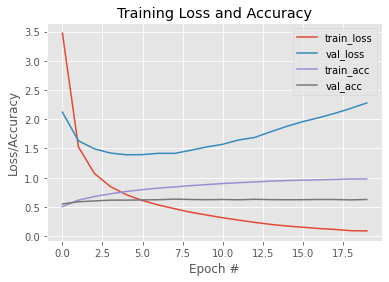

In [ ]:
# Import the necessary packages
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from google.colab import drive

# Compilar el modelo
print("[INFO]: Compilando el modelo...")
pre_trained_model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0005,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08), metrics=["accuracy"]) 

# Entrenamiento de la red
print("[INFO]: Entrenando la red...")
H_pre = pre_trained_model.fit(trainX, trainY, batch_size=128, epochs=20, validation_split=0.2)
# Almaceno el modelo en Drive
# Montamos la unidad de Drive
drive.mount('/content/drive') 
# Almacenamos el modelo empleando la función mdoel.save de Keras
pre_trained_model.save(BASE_FOLDER+"deepCNN_CIFAR10_pretrained.h5") #(X)

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
# Efectuamos la predicción (empleamos el mismo valor de batch_size que en training)
predictions = pre_trained_model.predict(testX, batch_size=128)
# Sacamos el report para test
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames)) 

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H_pre.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H_pre.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H_pre.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H_pre.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

#### **- Creando el top model y descongelando bloques convolucionales (FINE TUNING)**

In [ ]:
# Imports que vamos a necesitar
%tensorflow_version 1.x
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

#Cargamos el dataset CIFAR10
(trainX, trainY), (testX, testY) = cifar10.load_data() 

# Normalizamos las entradas de idéntica forma a como lo hicieron para entrenar la VGG16 en imageNet
trainX = imagenet_utils.preprocess_input(trainX) 
testX = imagenet_utils.preprocess_input(testX) 

# Definimos dimensiones de nuestros datos de entrada y lista con las categorias de las clases
input_shape = (32, 32, 3) 
labelNames = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camión"] 

# En caso de inestabilidades numéricas pasar datos a one-hot encoding
trainY = to_categorical(trainY) 
testY = to_categorical(testY) 

# Importamos VGG16 con pesos de imagenet y sin top_model especificando tamaño de entrada de datos
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
# Mostramos la arquitectura
base_model.summary()

# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# En base_model.layers.name tenemos la información del nombre de la capa
#Por defecto todas las layer trainable tiene el valor de True
#El objetivo acá es recorrer layers del modelo pre entrenado y decirle cuales layers quiero que queden congeladas. 
for layer in base_model.layers: 
  if layer.name == 'block3_conv1': 
    break 
  layer.trainable = False 
  print('Capa ' + layer.name + ' congelada...') 

# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output 
x = Flatten()(last) 
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x) 
x = Dense(256, activation='relu', name='fc2')(x) 
x = Dense(10, activation='softmax', name='predictions')(x) 
model = Model(base_model.input, x) 

# Compilamos el modelo
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) 

# Vamos a visualizar el modelo prestando especial atención en el número de pesos total y el número de pesos entrenables.
# ¿tiene sentido en comparación al ejemplo de transfer learning?
model.summary() 

# Entrenamos el modelo
H = model.fit(trainX, trainY, validation_split=0.2, batch_size=256, epochs=20, verbose=1) 

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...")
predictions = model.predict(testX, batch_size=64) 
# Obtener el report de clasificación
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames)) 

# Gráficas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

TensorFlow 1.x selected.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_____________________

KeyboardInterrupt: ignored

**EJERCICIO PROPUESTO:** Combinar fine tuning con la técnica de data augmentation para reducir overfitting.

## **VISUALIZANDO POR DENTRO UNA CNN**

#### **- Visualizar activaciones intermedias**

- Visualizar el output de las capas de la red
- 2D imagen por canal

In [ ]:
%tensorflow_version 1.x
from tensorflow.keras.datasets import cifar10
from sklearn.preprocessing import LabelBinarizer

# Importando y normalizando el set de datos CIFAR10
print("[INFO]: Loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
labelNames = ["Avión", "Automóvil", "Pájaro", "Gato", "Ciervo", "Perro", "Rana", "Caballo", "Barco", "Camión"]

#One-hot encoding
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

TensorFlow 1.x selected.
[INFO]: Loading CIFAR-10 data...


In [ ]:
from keras.models import load_model
model_augmentation = load_model(BASE_FOLDER+'resources/convnet_augmentation.h5')
model_augmentation.summary()

TensorFlow is already loaded. Please restart the runtime to change versions.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 64)        36928     
___________________________________________

In [ ]:
# extraer outputs
from keras import models

output_layers = [layer.output for layer in model_augmentation.layers[:7]]
activation_model = models.Model(inputs=model_augmentation.input, outputs=output_layers)

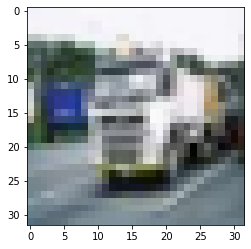

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img
%matplotlib inline

# Visualizando imagen 
sample = 1000
input_img = trainX[sample].reshape((1,32,32,3))
plt.imshow(array_to_img(trainX[sample]))
plt.show()

In [ ]:
# Activacion, 32 canales, feature map de 30x30
layer = 0
activations = activation_model.predict(input_img)
layer_activation = activations[layer]
print(layer_activation.shape)

(1, 30, 30, 32)


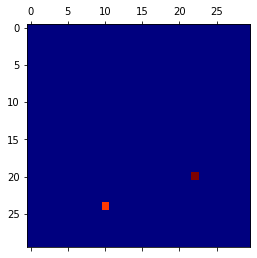

In [ ]:
# Mostrar cualquier canal
channel = 31
plt.matshow(layer_activation[0,:,:,channel], cmap='jet')

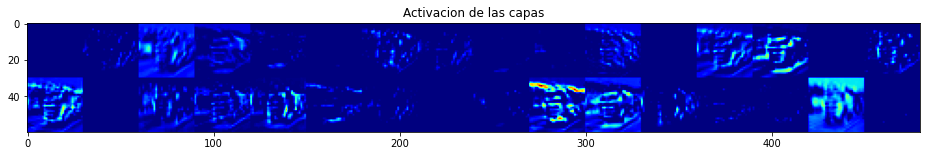

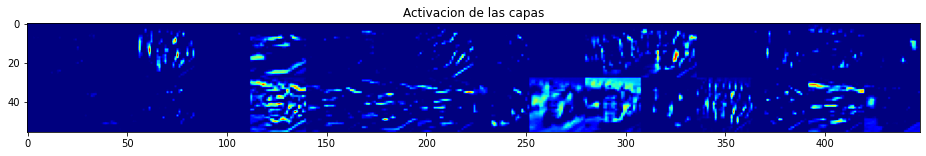

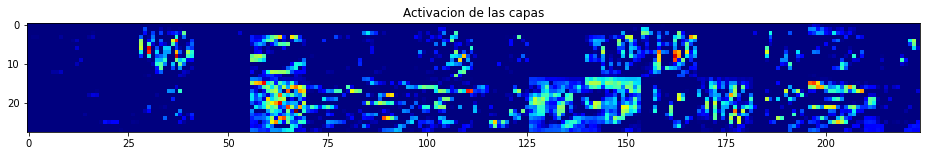

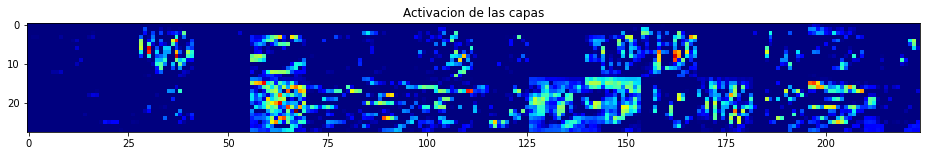

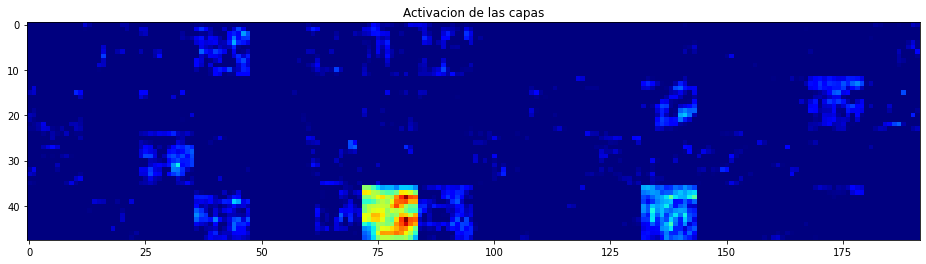

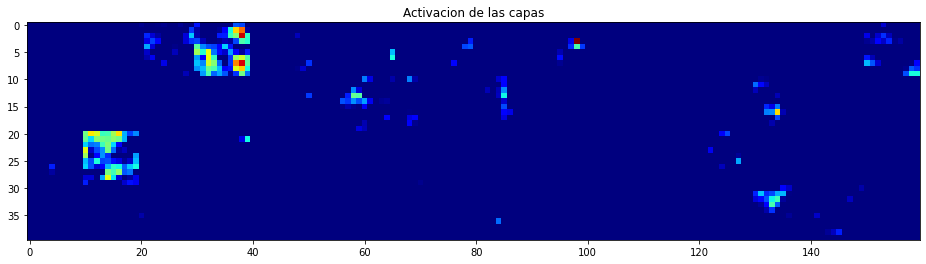

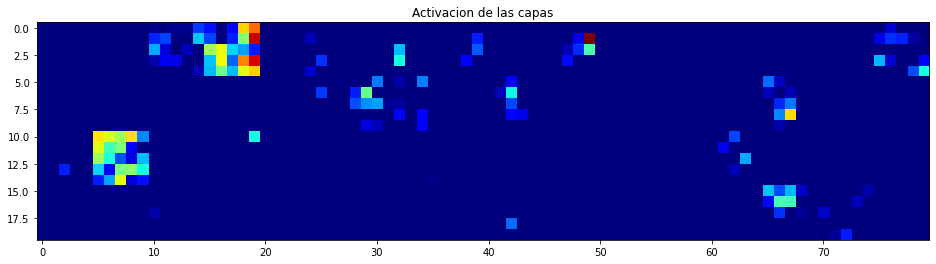

In [ ]:
import numpy as np
# Visualizar todas las capas
layer_names = [layer.name for layer in model_augmentation.layers[:7]]
images_per_row = 16
display_grid = []
for layer_name, layer_activation in zip(layer_names,activations):
    # Número de features
    n_features = layer_activation.shape[-1]
    # Tamaño de cada feature
    size = layer_activation.shape[1]
    # Número de columnas a mostrar
    n_cols = n_features // images_per_row
    
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_img = layer_activation[0,:,:,col * images_per_row + row]
            display_grid[col * size : (col + 1) * size,
                        row * size : (row + 1) * size] = channel_img
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                       scale * display_grid.shape[0]))
    plt.title('Activacion de las capas')
    plt.grid(False)
    plt.imshow(display_grid,aspect='auto',cmap='jet')


### Interpretacion
- Capas iniciales son como detectores de bordes
- Capas más profundas son más difíciles de interpretar (abstractas) y tienen información relativa a la clase de imagen
- La activación de capas profundas es más dispersa (sparse)

#### **- Visualizar filtros convolucionales**

- Visualizar las imagenes que maximizan la respuesta a un filtro

In [ ]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',include_top=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Using TensorFlow backend.


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
import numpy as np

def gen_max_response_pattern(layer_name, filter_index, size=32):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Para obtener el patron que responde de forma máxima, utilizamos descenso del gradiente
    grads = K.gradients(loss,model.input)[0] # Seleccionar el primero, ya que esto devuelve una lista
    # Normalización para ayudar al proceso del gradiente
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # Última constante para evitar dividir por 0
    # Definir funcion que calcula la pérdida y el gradiente de la imagen
    iterate = K.function([model.input], [loss,grads])
    loss_value, grads_value = iterate([np.zeros((1,size,size,3))])
    
    # Iniciamos con imagen aleatoria
    input_img_data = np.random.random((1,size,size,3)) * 20 + 128

    step = 1. # Magnitud de cada actualizacion en el gradiente
    n_steps = 40 # Número de iteraciones
    for i in range(n_steps):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    # Procesar la imagen resultante
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.1
    img += 0.5
    img = np.clip(img,0,1)
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

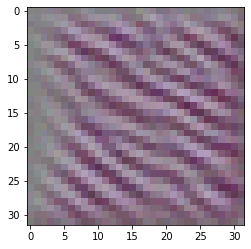

In [ ]:
# mostrar un patron para un filtro
import matplotlib.pyplot as plt
%matplotlib inline

layer_name = 'block2_conv1'
filter_index = 112 # canal a estudiar

img = gen_max_response_pattern(layer_name,filter_index,32)
plt.imshow(img)

**EJERCICIO PROPUESTO:** Mostrar los patrones de maxima activacion para todos los filtros de una capa.

#### **- Visualizar hetmaps de activación por clase**

- Útil para averiguar qué partes de la imagen contribuyen más a la decisión
- Interesante para saber qué pasa cuando se cometen errores

In [ ]:
# Técnica utiliza gradientes Ramprasaath, R. Selvaraju et al. (2017). https://arxiv.org/abs/1610.02391
from keras.applications import VGG16

model = VGG16(weights='imagenet',include_top=True)

553467904/553467096 [==============================] - 27s 0us/step


In [ ]:
from keras.preprocessing import image 
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# Cargar imagen de gato
img = image.load_img(BASE_FOLDER+'resources/cat.jpg', target_size=(224,224))
x = image.img_to_array(img) # a array de (224,224,3)
x = np.expand_dims(x, axis=0) # a array de (1,224,224,3)
x = preprocess_input(x)

In [ ]:
# Testeando el output
prediction = model.predict(x)
print(decode_predictions(prediction))

40960/35363 [==================================] - 0s 0us/step
[[('n02123045', 'tabby', 0.3503666), ('n02124075', 'Egyptian_cat', 0.32183623), ('n02123159', 'tiger_cat', 0.2860135), ('n02127052', 'lynx', 0.013260278), ('n04040759', 'radiator', 0.0008939235)]]


In [ ]:
tabby_output_index = np.argmax(prediction[0])
tabby_output = model.output[:,tabby_output_index]
last_conv_layer = model.get_layer('block5_conv3')

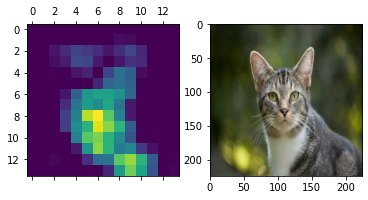

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K

grads = K.gradients(tabby_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))
iterate = K.function( [model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

# Multiplicar cada canal en el feature map por como de importante el canal es con respecto a la clase "tabby"
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

# Visualizar
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
fig,axes = plt.subplots(1,2)
axes[0].matshow(heatmap)
axes[1].imshow(img)
plt.show()

**EJERCICIO PROPUESTO:** Obtener el heatmap para las otras clases en la lista de prediccion (Egyptian_cat, tiger_cat, etc.).